# Quora Insincere Questions Classification

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
from textblob import TextBlob
import string
from collections import Counter
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from PIL import Image
import operator
from langdetect import detect
from langdetect import DetectorFactory
from tqdm import tqdm
warnings.filterwarnings('ignore')

from keras.metrics import *
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.initializers import Constant
from keras.models import Sequential
from scipy import sparse
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from googletrans import Translator

trans = Translator()
DetectorFactory.seed = 0
stop_words = set(stopwords.words('english'))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

Using TensorFlow backend.


In [2]:
print ("The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.")

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.


In [3]:
# Importing the dataset
df = pd.read_csv("train.csv")

In [4]:
print ("The shape of the dataset is : ", df.shape)

The shape of the dataset is :  (1306122, 3)


In [5]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [7]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [8]:
# Checing for the null values
df.isnull().sum(axis = 0)

qid              0
question_text    0
target           0
dtype: int64

### Preprocessing

In [9]:
# Contraction Dictionary for the expansion
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
    "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
    "you’re": "you are", "you’re": "you are", "you’ve": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [10]:
# Function to clean the html from the Questions
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the questions
def preprocessing(question):
    global question_sent
    
    # Converting to lowercase
    #question = question.str.lower()
    
    # Removing the HTML
    question = question.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    question = question.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    question = question.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Mapping the contractions
    question = question.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    question = question.apply(lambda x: x.replace("'s", ''))
    question = question.apply(lambda x: x.replace('’s', ''))
    question = question.apply(lambda x: x.replace("\'s", ''))
    question = question.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    question = question.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing punctuations from the question
    question = question.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might lead to a white space
    question = question.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    # question = question.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return question

In [35]:
df['processed_text'] = preprocessing(df['question_text'])
df.head(20)

,qid,question_text,target,processed_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How did Otto von Guericke used the Magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D to a mountain b...
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0,Is Gaza slowly becoming Auschwitz Dachau or Tr...
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0,Why does Quora automatically ban conservative ...
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0,Is it crazy if I wash or wipe my groceries off...
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0,Is there such a thing as dressing moderately a...
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0,Is it just me or have you ever been in this ph...


In [12]:
# Lemmatization using WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['processed_text'] = df['processed_text'].apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))

### Using Embedding

In [11]:
# Opening the GloVe File for embedding
embeddings_index = {}
word_embedding_file = open('glove.840B.300d.txt', encoding="utf-8")
for line in word_embedding_file:
    values = line.split(' ')
    word = values[0]
    coefs = np.array(values[1:], dtype = 'float64')
    embeddings_index[word] = coefs
word_embedding_file.close()

print (len(embeddings_index))

2196016


In [12]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [13]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [14]:
vocab = build_vocab(df['question_text'])
# Here vocab[word], n_known_words and nb_unknown_words are the total number of words in the text sum ex how : 30000

In [15]:
# Checking the coverage of the embedding
oov = check_coverage(vocab, embeddings_index)

Found embeddings for 33.159% of vocab
Found embeddings for  88.159% of all text


In [16]:
# Punctuations not present in the GloVe Embedding
def punct(embeddings_index, punctuation):
    punctuations_notpresent = []
    for i in punctuation:
        if i not in embeddings_index.keys():
            punctuations_notpresent.append(i)
    return "".join(punctuations_notpresent)

In [17]:
punctuation_embed = punct(embeddings_index, punctuation)
print ("Punctuations : ", punctuation)
print("Punctuations not present : ", punctuation_embed)

Punctuations :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""“”’∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&
Punctuations not present :  ₹


In [18]:
# Removing the punctuation if the punctuation not present in the GloVe embedding
df['embed_text'] = df['question_text'].apply(lambda x: ''.join(word for word in x if word not in punctuation_embed))

In [19]:
# Expanding Contractions
df['embed_text'] = df['embed_text'].apply(lambda x: expand_contractions(x))

In [20]:
# # Checking the language and translating the question in English
# def langdec_trans(question):
#     try :
#         lang = detect(question)
#         if lang not in 'en':
#             converted_text = trans.translate(question).text
#             print (converted_text)
#             return converted_text
#         return question
#     except :
#         return question
#
# # Converting the questions now
# df['embed_text'] = df['embed_text'].apply(lambda x: langdec_trans(x))

In [21]:
# Checking the language and translating the question in English
questions_converted = []
for i in tqdm(range(len(df))):
    converted_text = trans.translate(df['embed_text'][i]).text
    questions_converted.append(converted_text)

  1%|▏         | 19486/1306122 [1:27:50<96:40:06,  3.70it/s] 


ReadTimeout: The read operation timed out

In [ ]:
df['embed_text'] = questions_converted
df.to_csv('embed_file.csv')

In [ ]:
df.head(20)

In [ ]:
# The Special characters
uncommon_string = ['☹', 'Ź', 'Ż', 'ἰ', 'ή', 'Š', '＞', 'ξ','ฉ', 'ั', 'น', 'จ', 'ะ', 'ท', 'ำ', 'ใ', 'ห', '้', 'ด', 'ี',
                   '่', 'ส', 'ุ', 'Π', 'प', 'ऊ', 'Ö', 'خ', 'ب', 'ஜ', 'ோ', 'ட', '', '「', 'ẽ', '½', '△', 'É', 'ķ',
                   'ï', '¿', 'ł', '북', '한', '¼', '∆', '≥', '⇒', '¬', '∨', 'č', 'š', '∫', 'ḥ', 'ā', 'ī', 'Ñ', 'à',
                   '▾', 'Ω', '＾', 'ý', 'µ', '?', '!', '.', ',', '"', '#', '$', '%', '\\', "'", '(', ')', '*', '+',
                   '-', '/', ':', ';', '<', '=', '>', '@', '[', ']', '^', '_', '`', '{', '|', '}', '~', ' ', '“',
                   '”', '’', 'é', 'á', '′', '…', 'ɾ', '̃', 'ɖ', 'ö', '–', '‘', 'ऋ', 'ॠ', 'ऌ', 'ॡ', 'ò', 'è', 'ù',
                   'â', 'ğ', 'म', 'ि', 'ल', 'ग', 'ई', 'क', 'े', 'ज', 'ो', 'ठ', 'ं', 'ड', 'Ž', 'ž', 'ó', '®', 'ê',
                   'ạ', 'ệ', '°', 'ص', 'و', 'ر', 'ü', '²', '₹', 'ú', '√', 'α', '→', 'ū', '—', '£', 'ä', '️', 'ø',
                   '´', '×', 'í', 'ō', 'π', '÷', 'ʿ', '€', 'ñ', 'ç', 'へ', 'の', 'と', 'も', '↑', '∞', 'ʻ', '℅''ι',
                   '•', 'ì', '−', 'л', 'я', 'д', 'ل', 'ك', 'م', 'ق', 'ا', '∈', '∩', '⊆', 'ã', 'अ', 'न', 'ु', 'स',
                   '्', 'व', 'ा', 'र', 'त', '§', '℃', 'θ', '±', '≤', 'उ', 'द', 'य', 'ब', 'ट', '͡', '͜', 'ʖ', '⁴', '™',
                   'ć', 'ô', 'с', 'п', 'и', 'б', 'о', 'г', '≠', '∂', 'आ', 'ह', 'भ', 'ी', '³', 'च', '...', '⌚', '⟨',
                   '⟩', '∖', '˂', 'ⁿ', '⅔', 'న', 'ీ', 'క', 'ె', 'ం', 'ద', 'ు', 'ా', 'గ', 'ర', 'ి', 'చ', 'র', 'ড়',
                   'ঢ়', 'સ', 'ં', 'ઘ', 'ર', 'ા', 'જ', '્', 'ય', 'ε', 'ν', 'τ', 'σ', 'ş', 'ś', 'س', 'ت',
                   'ط', 'ي', 'ع', 'ة', 'د', 'Å', '☺', 'ℇ', '❤', '♨', '✌', 'ﬁ', 'て', '„', 'Ā', 'ត', 'ើ',
                   'ប', 'ង', '្', 'អ', 'ូ', 'ន', 'ម', 'ា', 'ធ', 'យ', 'វ', 'ី', 'ខ', 'ល', 'ះ', 'ដ', 'រ',
                   'ក', 'ឃ', 'ញ', 'ឯ', 'ស', 'ំ', 'ព', 'ិ', 'ៃ', 'ទ', 'គ', '¢', 'つ', 'や', 'ค', 'ณ', 'ก',
                   'ล', 'ง', 'อ', 'ไ', 'ร', 'į', 'ی', 'ю', 'ʌ', 'ʊ', 'י', 'ה', 'ו', 'ד', 'ת', 'ᠠ', 'ᡳ', '᠌', 'ᠰ',
                   'ᠨ', 'ᡤ', 'ᡠ', 'ᡵ', 'ṭ', 'ế', 'ध', 'ड़', 'ß', '¸', 'ч',  'ễ', 'ộ', 'फ', 'μ', '⧼', '⧽', 'ম',
                   'হ', 'া', 'ব', 'ি', 'শ', '্', 'প', 'ত', 'ন', 'য়', 'স', 'চ', 'ছ', 'ে', 'ষ', 'য', '়', 'ট',
                   'উ', 'থ', 'ক', 'ῥ', 'ζ', 'ὤ', 'Ü', 'Δ', '내', '제', 'ʃ', 'ɸ', 'ợ', 'ĺ', 'º', 'ष', '♭', '़',
                   '✅', '✓', 'ě', '∘', '¨', '″', 'İ', '⃗', '̂', 'æ', 'ɔ', '∑', '¾', 'Я', 'х', 'О', 'з', 'ف', 'ن',
                   'ḵ', 'Č', 'П', 'ь', 'В', 'Φ', 'ỵ', 'ɦ', 'ʏ', 'ɨ', 'ɛ', 'ʀ', 'ċ', 'օ', 'ʍ', 'ռ', 'ք', 'ʋ', '兰',
                   'ϵ', 'δ', 'Ľ', 'ɒ', 'î', 'Ἀ', 'χ', 'ῆ', 'ύ', 'ኤ', 'ል', 'ሮ', 'ኢ', 'የ', 'ኝ', 'ን', 'አ', 'ሁ', '≅',
                   'ϕ', '‑', 'ả', '￼', 'ֿ', 'か', 'く', 'れ', 'ő', '－', 'ș', 'ן', 'Γ', '∪', 'φ', 'ψ', '⊨', 'β', '∠',
                   'Ó', '«', '»', 'Í', 'க', 'வ', 'ா', 'ம', '≈', '⁰', '⁷', 'ấ', 'ũ', '눈', '치', 'ụ', 'å', '،', '＝',
                   '（', '）', 'ə', 'ਨ', 'ਾ', 'ਮ', 'ੁ', '︠', '︡', 'ɑ', 'ː', 'λ', '∧', '∀', 'Ō', 'ㅜ', 'Ο', 'ς', 'ο', 'η',
                   'Σ', 'ण', '大','能', '化', '生', '水', '谷', '精', '微', 'ル', 'ー', 'ジ', 'ュ', '支', '那', '¹',
                   'マ', 'リ', '仲', '直', 'り', 'し', 'た', '主', '席', '血', '⅓', '漢', '髪', '金', '茶', '訓', '読',
                   '黒', 'ř', 'あ', 'わ', 'る', '胡', '南', '수', '능', '广', '电', '总', 'ί', '서', '로', '가', '를',
                   '행', '복', '하', '게', '기', '乡', '故', '爾', '汝', '言', '得', '理', '让', '骂', '野', '比', 'び',
                   '太', '後', '宮', '甄', '嬛', '傳', '做', '莫', '你', '酱', '紫', '甲', '骨', '陳', '宗', '陈', '什',
                   '么', '说', '伊', '藤', '長', 'ﷺ', '僕', 'だ', 'け', 'が', '街', '◦', '火', '团', '表',  '看', '他',
                   '顺', '眼', '中', '華', '民', '國', '許', '自', '東', '儿', '臣', '惶', '恐', 'っ', '木', 'ホ', 'ج',
                   '教', '官', '국', '고', '등', '학', '교', '는', '몇', '시', '간', '업', '니', '本', '語', '上', '手',
                   'で', 'ね', '台', '湾', '最', '美', '风', '景', 'Î', '≡', '皎', '滢', '杨', '∛', '簡', '訊', '短',
                   '送', '發', 'お', '早', 'う', '朝', 'ش', 'ه', '饭', '乱', '吃', '话', '讲', '男', '女', '授', '受',
                   '亲', '好', '心', '没', '报', '攻', '克', '禮', '儀', '統', '已', '經', '失', '存', '٨', '八', '‛',
                   '字', '：', '别', '高', '兴', '还', '几', '个', '条', '件', '呢', '觀', '《', '》', '記', '宋', '楚',
                   '瑜', '孫', '瀛', '枚', '无', '挑', '剔', '聖', '部', '頭', '合', '約', 'ρ', '油', '腻', '邋', '遢',
                   'ٌ', 'Ä', '射', '籍', '贯', '老', '常', '谈', '族', '伟', '复', '平', '天', '下', '悠', '堵', '阻',
                   '愛', '过', '会', '俄', '罗', '斯', '茹', '西', '亚', '싱', '관', '없', '어', '나', '이', '키', '夢',
                   '彩', '蛋', '鰹', '節', '狐', '狸', '鳳', '凰', '露', '王', '晓', '菲', '恋', 'に', '落', 'ち', 'ら',
                   'よ', '悲', '反', '清', '復', '明', '肉', '希', '望', '沒', '公', '病', '配', '信', '開', '始', '日',
                   '商', '品', '発', '売', '分', '子', '创', '意', '梦', '工', '坊', 'ک', 'پ', 'ڤ', '蘭', '花', '羡',
                   '慕', '和', '嫉', '妒', '是', '样', 'ご', 'め', 'な', 'さ', 'い', 'す', 'み', 'ま', 'せ', 'ん', '音',
                   '红', '宝', '书', '封', '柏', '荣', '江', '青', '鸡', '汤', '文', '粵', '拼', '寧', '可', '錯', '殺',
                   '千', '絕', '放', '過', '」', '之', '勢', '请', '国', '知', '识', '产', '权', '局', '標', '點', '符',
                   '號', '新', '年', '快', '乐', '学', '业', '进', '步', '身', '体', '健', '康', '们', '读', '我', '的',
                   '翻', '译', '篇', '章', '欢', '迎', '入', '坑', '有', '毒', '黎', '氏', '玉', '英', '啧', '您', '这',
                   '口', '味', '奇', '特', '也', '就', '罢', '了', '非', '要', '以', '此', '为', '依', '据', '对', '人',
                   '家', '批', '判', '一', '番', '不', '地', '道', '啊', '谢', '六', '佬']

In [ ]:
# Special Characters present in the embedding index
char_present = []
final_uncommon = uncommon_string.copy()
length = len(uncommon_string)
for i in range(length):
    if uncommon_string[i] in embeddings_index.keys():
        char_present.append(uncommon_string[i])
        final_uncommon.remove(uncommon_string[i])

print ("Total Special Characters present : ", length)
print ("Total Special Characters present in the GloVe Embedding : ", len(char_present))
print ("Total Special Characters not present in the GloVe Embedding : ", len(final_uncommon))
special_char = "".join(final_uncommon)

In [ ]:
# Removing the Special Characters
df['embed_text'] = df['embed_text'].apply(lambda x: ''.join(word for word in x if word not in special_char))

In [ ]:
df.to_csv('embed_file_final.csv')

In [ ]:
# Checking the coverage by GloVe after preprocessing
vocab = build_vocab(df['embed_text'])
oov = check_coverage(vocab, embeddings_index)

In [36]:
trans.translate('あからさまに機嫌悪いオーラ出してんのに話しかけてくるし、からかってくる男に、今そう言う冗談で笑える気分じゃないから一人にしてって言ったら何があったの？話聞くよって言われたんだけど、オメエだよオメエと話してんのが苦痛なんだよ。シネ。').text

"He talks to me out loud with an aura of a bad mood, and I don't feel like laughing at the man who makes fun of me, so what happened when I said alone? I was told to listen, but it's Omee. It's a pain to talk to Omee. Cine."

In [39]:
df.head()

,qid,question_text,target,embed_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time Does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How did Otto von Guericke used the Magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D to a mountain b...


In [47]:
df.embed_text.str.contains('✅')

0          False
1          False
2          False
3          False
4          False
           ...  
1306117    False
1306118    False
1306119    False
1306120    False
1306121    False
Name: embed_text, Length: 1306122, dtype: bool

In [64]:
a = df.loc[df.question_text.str.contains('番'), 'embed_text']

In [66]:
a = str(a)

In [68]:
detect(a)

'en'

In [58]:
embeddings_index['☹']

array([ 2.7669e-01, -2.4735e-01,  2.4803e-01,  3.0500e-01, -4.1878e-01,
       -1.8720e-01, -2.5278e-01, -1.0123e-01, -6.9367e-02, -1.7964e+00,
        4.9123e-01, -5.8016e-02, -1.5295e-01, -1.1179e-01, -1.0361e+00,
        1.2194e-01,  1.7240e-01, -8.8647e-01, -3.3808e-02,  9.4192e-01,
        1.6794e-01,  7.0298e-01, -1.5698e-01,  8.8215e-02, -4.0418e-01,
        3.6710e-01, -1.4297e-01, -1.1813e-01,  2.0529e-01,  4.5819e-01,
        4.6781e-01, -1.7974e-01,  4.4968e-01, -4.8552e-01, -7.9493e-01,
        1.8298e-01, -4.1107e-01, -1.1343e-01,  3.5317e-01,  5.5576e-01,
        5.4647e-01,  2.8211e-01,  8.0380e-02, -2.6583e-01, -7.0784e-03,
        1.3116e-01, -4.8077e-01, -1.9162e-01, -9.2150e-01, -4.3331e-01,
       -5.7269e-01, -2.6217e-01,  4.7802e-01, -2.9386e-01, -7.6586e-02,
        4.9388e-01, -3.8544e-01, -3.1453e-01,  8.5632e-01, -2.3837e-01,
       -7.5003e-01,  5.5424e-02, -3.3139e-01, -6.6067e-01, -4.3590e-01,
        6.7089e-01,  1.4835e-02, -2.5217e-01, -7.8349e-01,  8.02

### Exploratory Data Analysis

#### Distribution of the Questions in the dataset

In [13]:
# Changing the target values for the EDA for now
df['target'] = df['target'].map({1 : 'Insincere', 0 : 'Sincere'})

The percentages of Sincere and Insincere Questions are :  [93.81298224821265, 6.187017751787352]


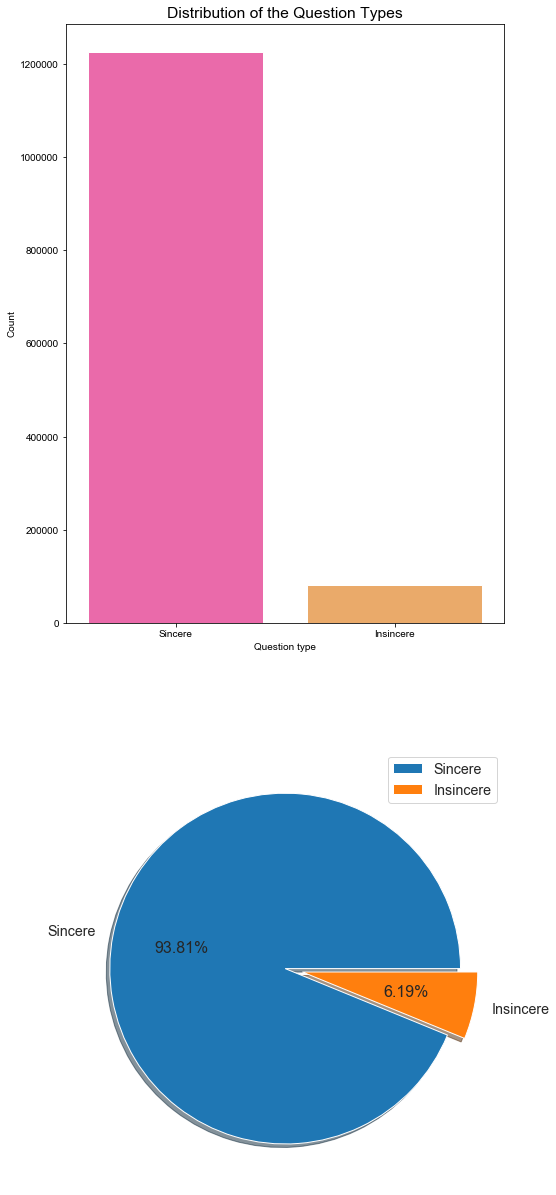

In [14]:
# Distribution of the Insincere and Sincere Questions
plt.rcParams['figure.figsize'] = [8, 18]
fig, ax = plt.subplots(2, 1)
sns.set(font_scale = 1.3, style = 'whitegrid')
distribution = sns.countplot(df['target'], palette = 'spring', ax = ax[0])
distribution.set(title = 'Distribution of the Question Types', xlabel = 'Question type', ylabel = 'Count');

# Creating the labels for the piechart
types = df['target'].value_counts()
labels = list(types.index)
aggregate = list(types.values)
percentage = [(x*100)/sum(aggregate) for x in aggregate]
print ("The percentages of Sincere and Insincere Questions are : ", percentage)

# Plotting the Piechart to see the percentage distribution of the questions
plt.rcParams.update({'font.size': 16})
explode = (0, 0.1)
ax[1].pie(aggregate, labels = labels, autopct='%1.2f%%', shadow=True, explode = explode)
plt.legend(labels, loc = 'best')
#plt.axis('equal')
plt.tight_layout()
plt.show()

#### Wordcloud for the Insincere Questions

In [15]:
# Some of the Insincere Questions
print (list(df.loc[df.target == 'Insincere', 'question_text'])[4])

Which races have the smallest penis?


In [16]:
print (list(df.loc[df.target == 'Insincere', 'question_text'])[115])

I'd like to ask a question that applies only to current/former police officers. I simply want to know why police officers seem to always choose protecting fellow cops over their own sense of humanity and right and wrong?


In [17]:
print (list(df.loc[df.target == 'Insincere', 'question_text'])[400])

Why doesn't Trump post on Twitter “F you people who hate me and comment about me, go to hell.”?


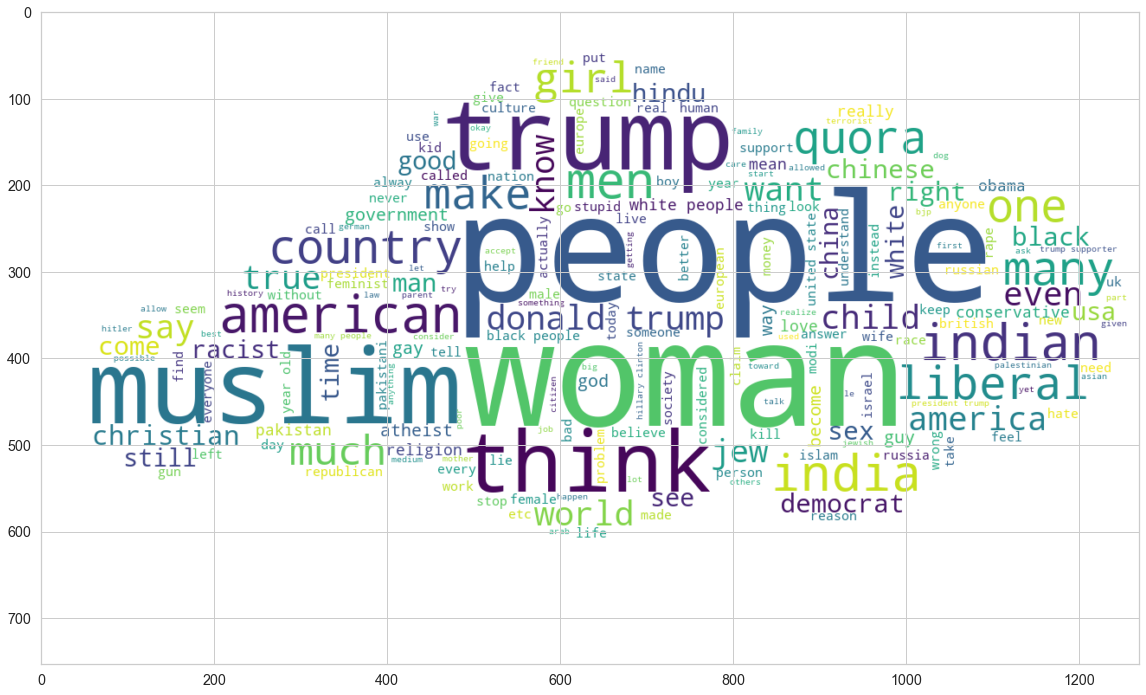

In [18]:
# Word Cloud Representation of the Insincere Questions on Quora
plt.rcParams['figure.figsize'] = [20, 12]
df_insincere = df.loc[df.target == 'Insincere', 'processed_text']
text = (' '.join(df_insincere))
# Masking Image for the wordcloud
our_mask = np.array(Image.open('image.jpg'))
# WORDCLOUD
cloud = WordCloud(width = 1000, height = 500, background_color = 'white', mask = our_mask).generate(text)
plt.imshow(cloud, interpolation = 'bilinear')

#### WordCloud for Sincere Questions

In [19]:
# Some of the Sincere Questions
df.loc[df.target == 'Sincere', 'question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [20]:
df.loc[df.target == 'Sincere', 'question_text'][100]

"What do physicists, mathematicians, computer scientists and philosophers think of David Deutsch's 'Constructor Theory'?"

In [21]:
df.loc[df.target == 'Sincere', 'question_text'][324234]

'Why some boys like bad girls?'

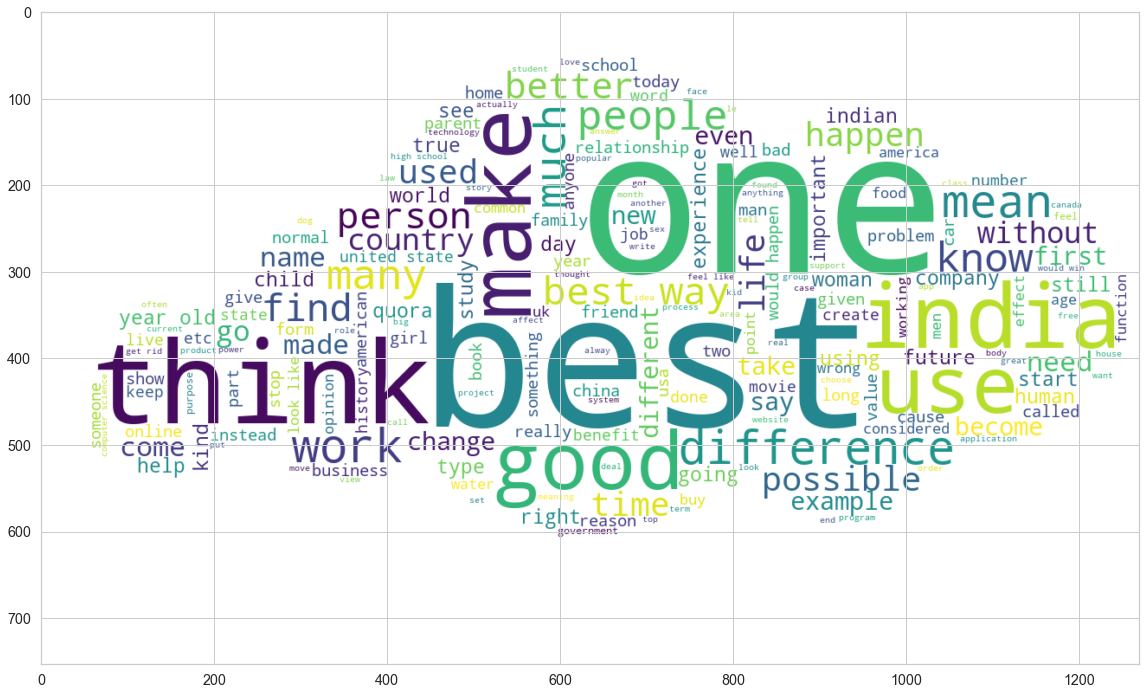

In [22]:
# Word Cloud Representation of the Insincere Questions on Quora
plt.rcParams['figure.figsize'] = [20, 12]
df_sincere = df.loc[df.target == 'Sincere', 'processed_text']
text_sin = (' '.join(df_sincere))
# WORDCLOUD
cloud = WordCloud(width = 1000, height = 500, background_color = 'white', mask = our_mask).generate(text_sin)
plt.imshow(cloud, interpolation = 'bilinear')

#### Number of words in each question

Maximum Number of words in the questions
target
Insincere     64
Sincere      134
Name: words_num, dtype: int64
Minimum Number of words in the questions
target
Insincere    1
Sincere      2
Name: words_num, dtype: int64


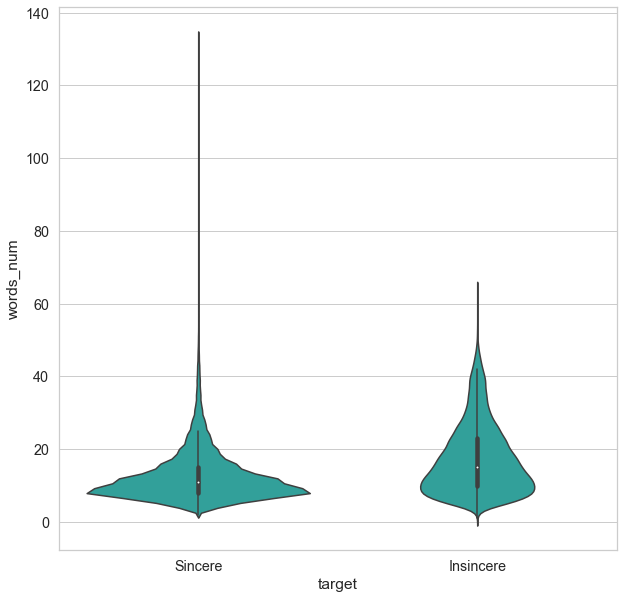

In [23]:
df['words_num'] = df['question_text'].apply(lambda x: len(str(x).split()))
plt.rcParams['figure.figsize'] = [10, 10]
# Violin plot
sns.violinplot(x = 'target', y = 'words_num', data = df, color = 'lightseagreen')
print ("Maximum Number of words in the questions")
print (df.groupby('target')['words_num'].max())
print ("Minimum Number of words in the questions")
print (df.groupby('target')['words_num'].min())

#### Number of unique words in each question

Maximum Number of unique words in the questions
target
Insincere    48
Sincere      96
Name: words_num_unique, dtype: int64
Minimum Number of unique words in the questions
target
Insincere    1
Sincere      2
Name: words_num_unique, dtype: int64


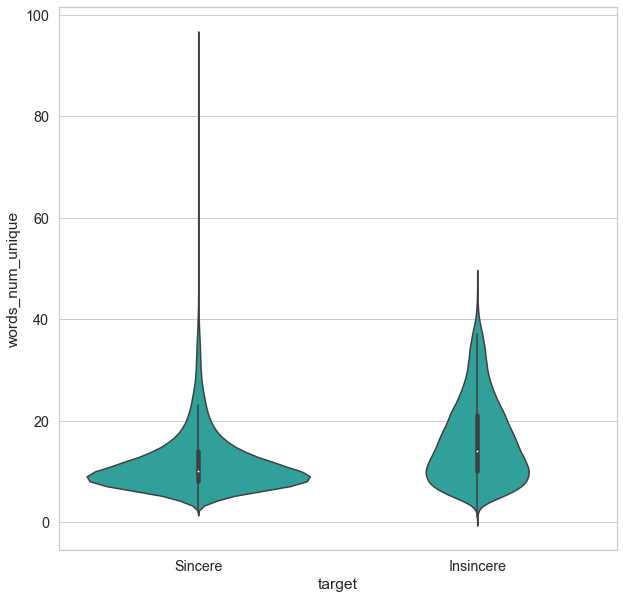

In [24]:
df['words_num_unique'] = df['question_text'].apply(lambda x: len(set(str(x).split())))
sns.violinplot(x = 'target', y = 'words_num_unique', data = df, color = 'lightseagreen')
print ("Maximum Number of unique words in the questions")
print (df.groupby('target')['words_num_unique'].max())
print ("Minimum Number of unique words in the questions")
print (df.groupby('target')['words_num_unique'].min())

#### Number of Characters in each question

Maximum Number of character in the questions
target
Insincere    1017
Sincere       752
Name: char_num, dtype: int64
Minimum Number of character in the questions
target
Insincere    1
Sincere      5
Name: char_num, dtype: int64


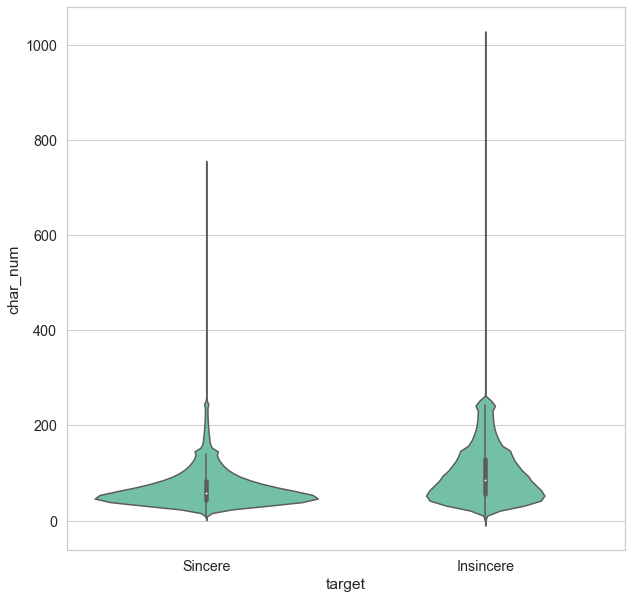

In [25]:
df['char_num'] = df['question_text'].apply(lambda x: len(str(x)))
sns.violinplot(x = 'target', y = 'char_num', data = df, color = 'mediumaquamarine')
print ("Maximum Number of character in the questions")
print (df.groupby('target')['char_num'].max())
print ("Minimum Number of character in the questions")
print (df.groupby('target')['char_num'].min())

#### Number of stop words in each question

Maximum Number of stopwords in the questions
target
Insincere    37
Sincere      56
Name: stopwords_num, dtype: int64
Minimum Number of stopwords in the questions
target
Insincere    0
Sincere      0
Name: stopwords_num, dtype: int64


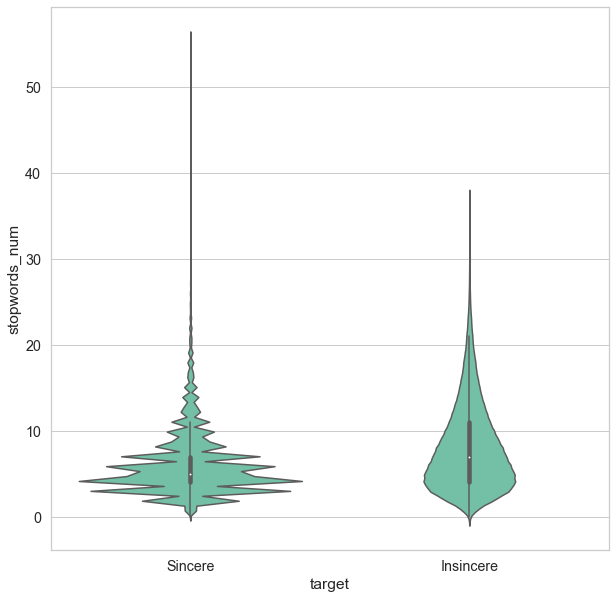

In [26]:
df['stopwords_num'] = df['question_text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
sns.violinplot(x = 'target', y = 'stopwords_num', data = df, color = 'mediumaquamarine')
print ("Maximum Number of stopwords in the questions")
print (df.groupby('target')['stopwords_num'].max())
print ("Minimum Number of stopwords in the questions")
print (df.groupby('target')['stopwords_num'].min())

#### Number of Punctuation words

Maximum Number of punctuations in the questions
target
Insincere    411
Sincere      158
Name: punctuation_num, dtype: int64
Minimum Number of punctuations in the questions
target
Insincere    0
Sincere      0
Name: punctuation_num, dtype: int64


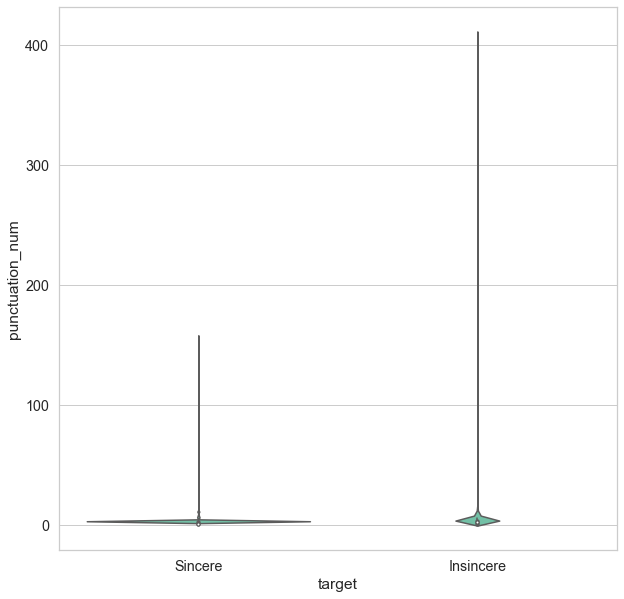

In [27]:
df["punctuation_num"] = df["question_text"].apply(lambda x: len([c for c in str(x) if c in punctuation]))
sns.violinplot(x = 'target', y = 'punctuation_num', data = df, color = 'mediumaquamarine')
print ("Maximum Number of punctuations in the questions")
print (df.groupby('target')['punctuation_num'].max())
print ("Minimum Number of punctuations in the questions")
print (df.groupby('target')['punctuation_num'].min())

#### Number of title case words in each question

Maximum Number of title case words in the questions
target
Insincere    37
Sincere      29
Name: titlecase_num, dtype: int64
Minimum Number of title case words in the questions
target
Insincere    0
Sincere      0
Name: titlecase_num, dtype: int64


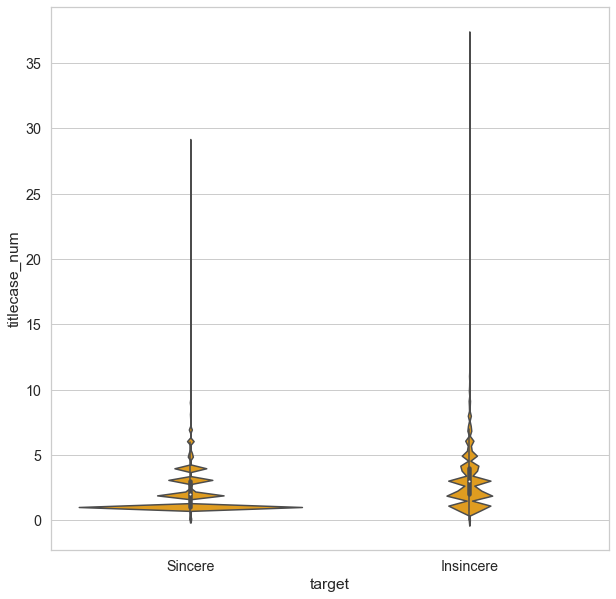

In [28]:
df['titlecase_num'] = df['question_text'].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
sns.violinplot(x = 'target', y = 'titlecase_num', data = df, color = 'orange')
print ("Maximum Number of title case words in the questions")
print (df.groupby('target')['titlecase_num'].max())
print ("Minimum Number of title case words in the questions")
print (df.groupby('target')['titlecase_num'].min())

#### Average Length of the words

Maximum average length of the words in the questions
target
Insincere    57.666667
Sincere      49.000000
Name: average_word_len, dtype: float64
Minimum average length of the words in the questions
target
Insincere    1.000000
Sincere      1.172414
Name: average_word_len, dtype: float64


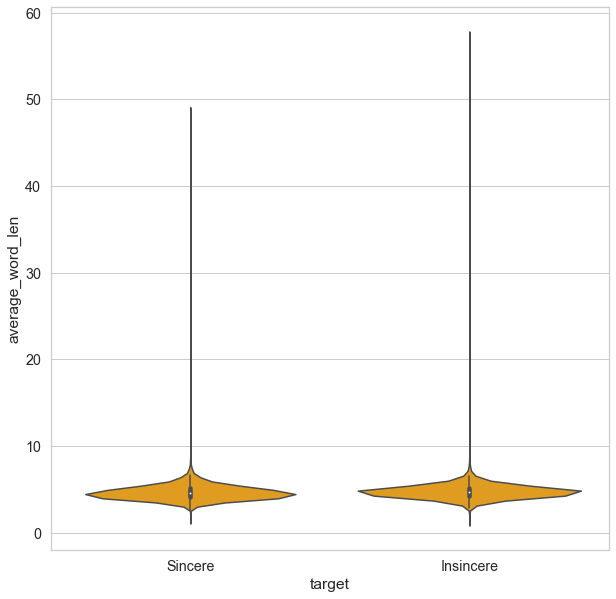

In [29]:
df['average_word_len'] = df['question_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
sns.violinplot(x = 'target', y = 'average_word_len', data = df, color = 'orange')
print ("Maximum average length of the words in the questions")
print (df.groupby('target')['average_word_len'].max())
print ("Minimum average length of the words in the questions")
print (df.groupby('target')['average_word_len'].min())

#### Ngrams

In [30]:
# Copying the dataset for the ngrams so that it won't effect the further processes
df_ = df.copy()
df_['question_text'] = df_['question_text'].str.replace(r'[^\w\d\s]',' ')

# Segregating the questions
df_insincere = " ".join(df_.loc[df_.target == 'Insincere', 'question_text'])
df_sincere = " ".join(df_.loc[df_.target == 'Sincere', 'question_text'])

# Tokenizing the Sentences
tokenized_insincere = word_tokenize(df_insincere)
tokenized_sincere = word_tokenize(df_sincere)

##### UNIGRAMS

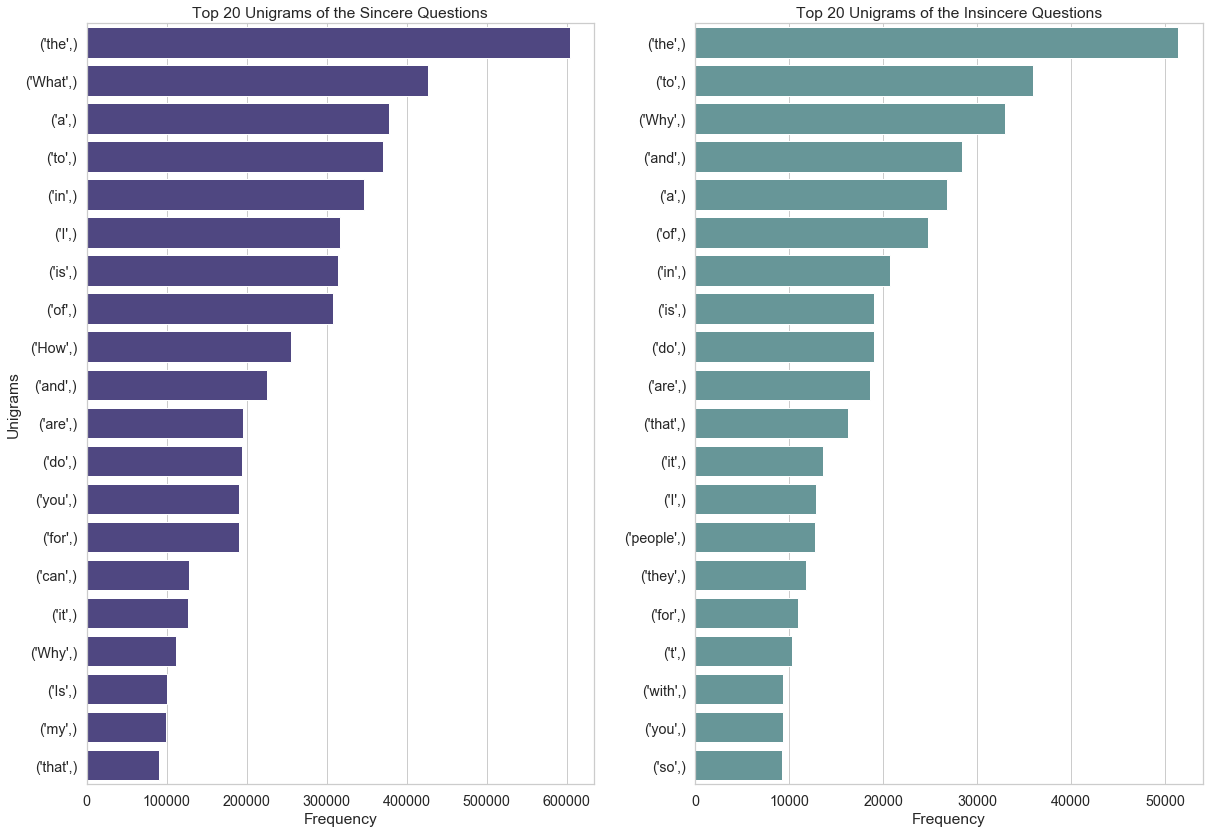

In [31]:
# Unigrams
unigram_insincere = ngrams(tokenized_insincere, 1)
unigram_sincere = ngrams(tokenized_sincere, 1)

# Making the Frequency chart for the Unigrams
frequency_insincere = Counter(unigram_insincere) 
frequency_sincere = Counter(unigram_sincere)

df_freq_insincere = pd.DataFrame(frequency_insincere.most_common(20))
df_freq_sincere = pd.DataFrame(frequency_sincere.most_common(20))

# Barplot that shows the top 20 Unigrams
plt.rcParams['figure.figsize'] = [20, 14]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.3, style = 'darkgrid')

sns_sincere = sns.barplot(x = df_freq_sincere[1], y = df_freq_sincere[0], color = 'darkslateblue', ax = ax[0])
sns_insincere = sns.barplot(x = df_freq_insincere[1], y = df_freq_insincere[0], color = 'cadetblue', ax = ax[1])

# Setting axes
sns_sincere.set(title = "Top 20 Unigrams of the Sincere Questions", ylabel = "Unigrams", xlabel = "Frequency")
sns_insincere.set(title = "Top 20 Unigrams of the Insincere Questions", xlabel = "Frequency", ylabel = "");

##### BIGRAMS

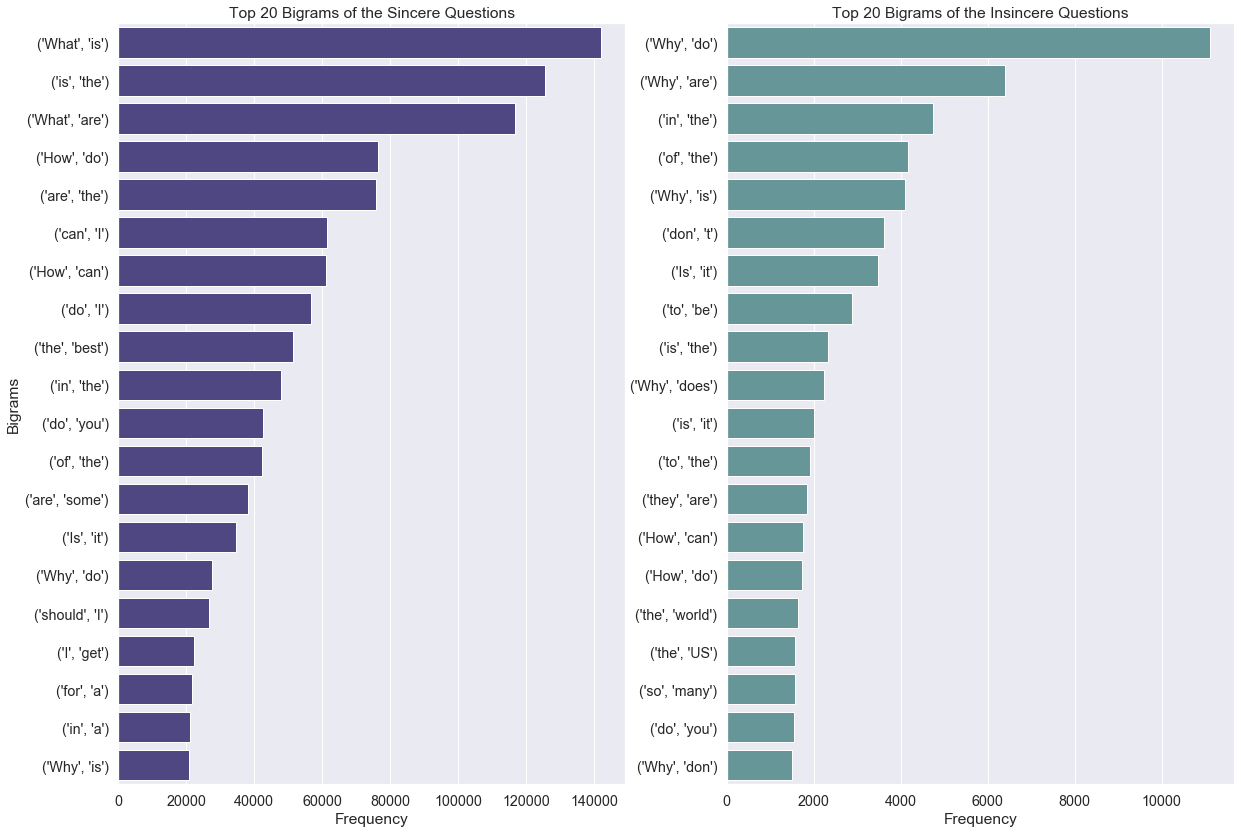

In [32]:
# Bigrams
bigram_insincere = ngrams(tokenized_insincere, 2)
bigram_sincere = ngrams(tokenized_sincere, 2)

# Making the Frequency chart for the Bigrams
frequency_insincere = Counter(bigram_insincere) 
frequency_sincere = Counter(bigram_sincere)

df_freq_insincere = pd.DataFrame(frequency_insincere.most_common(20))
df_freq_sincere = pd.DataFrame(frequency_sincere.most_common(20))

# Barplot that shows the top 20 Bigrams
plt.rcParams['figure.figsize'] = [20, 14]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.3, style = 'darkgrid')

sns_sincere = sns.barplot(x = df_freq_sincere[1], y = df_freq_sincere[0], color = 'darkslateblue', ax = ax[0])
sns_insincere = sns.barplot(x = df_freq_insincere[1], y = df_freq_insincere[0], color = 'cadetblue', ax = ax[1])

# Setting axes
sns_sincere.set(title = "Top 20 Bigrams of the Sincere Questions", ylabel = "Bigrams", xlabel = "Frequency")
sns_insincere.set(title = "Top 20 Bigrams of the Insincere Questions", xlabel = "Frequency", ylabel = "");

##### TRIGRAMS

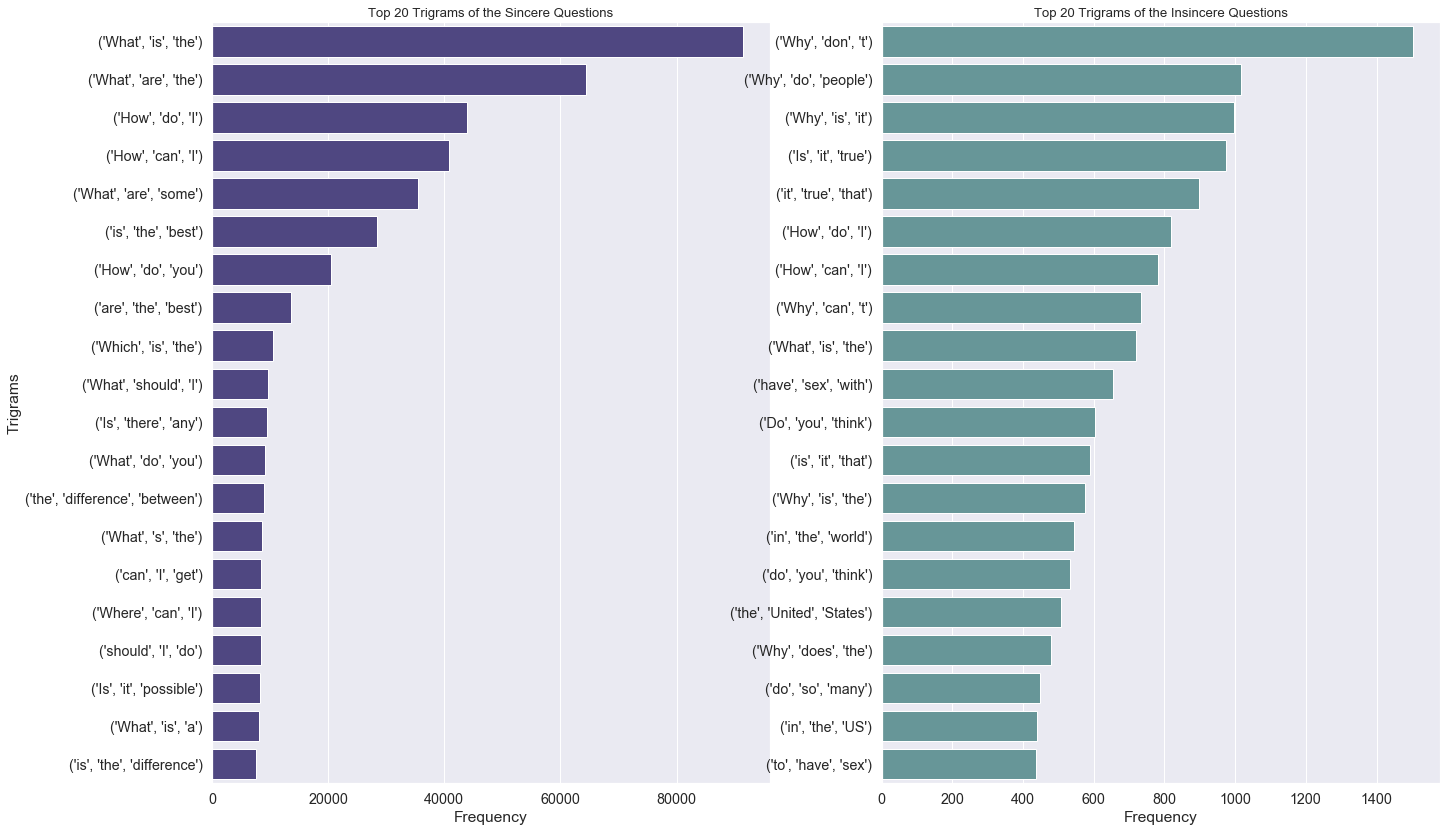

In [33]:
# Trigrams
trigram_insincere = ngrams(tokenized_insincere, 3)
trigram_sincere = ngrams(tokenized_sincere, 3)

# Making the Frequency chart for the Trigrams
frequency_insincere = Counter(trigram_insincere) 
frequency_sincere = Counter(trigram_sincere)

df_freq_insincere = pd.DataFrame(frequency_insincere.most_common(20))
df_freq_sincere = pd.DataFrame(frequency_sincere.most_common(20))

# Barplot that shows the top 20 Trigrams
plt.rcParams['figure.figsize'] = [22, 14]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.1, style = 'darkgrid')

sns_sincere = sns.barplot(x = df_freq_sincere[1], y = df_freq_sincere[0], color = 'darkslateblue', ax = ax[0])
sns_insincere = sns.barplot(x = df_freq_insincere[1], y = df_freq_insincere[0], color = 'cadetblue', ax = ax[1])

# Setting axes
sns_sincere.set(title = "Top 20 Trigrams of the Sincere Questions", ylabel = "Trigrams", xlabel = "Frequency")
sns_insincere.set(title = "Top 20 Trigrams of the Insincere Questions", xlabel = "Frequency", ylabel = "");

#### WordCount Plot

##### Insincere

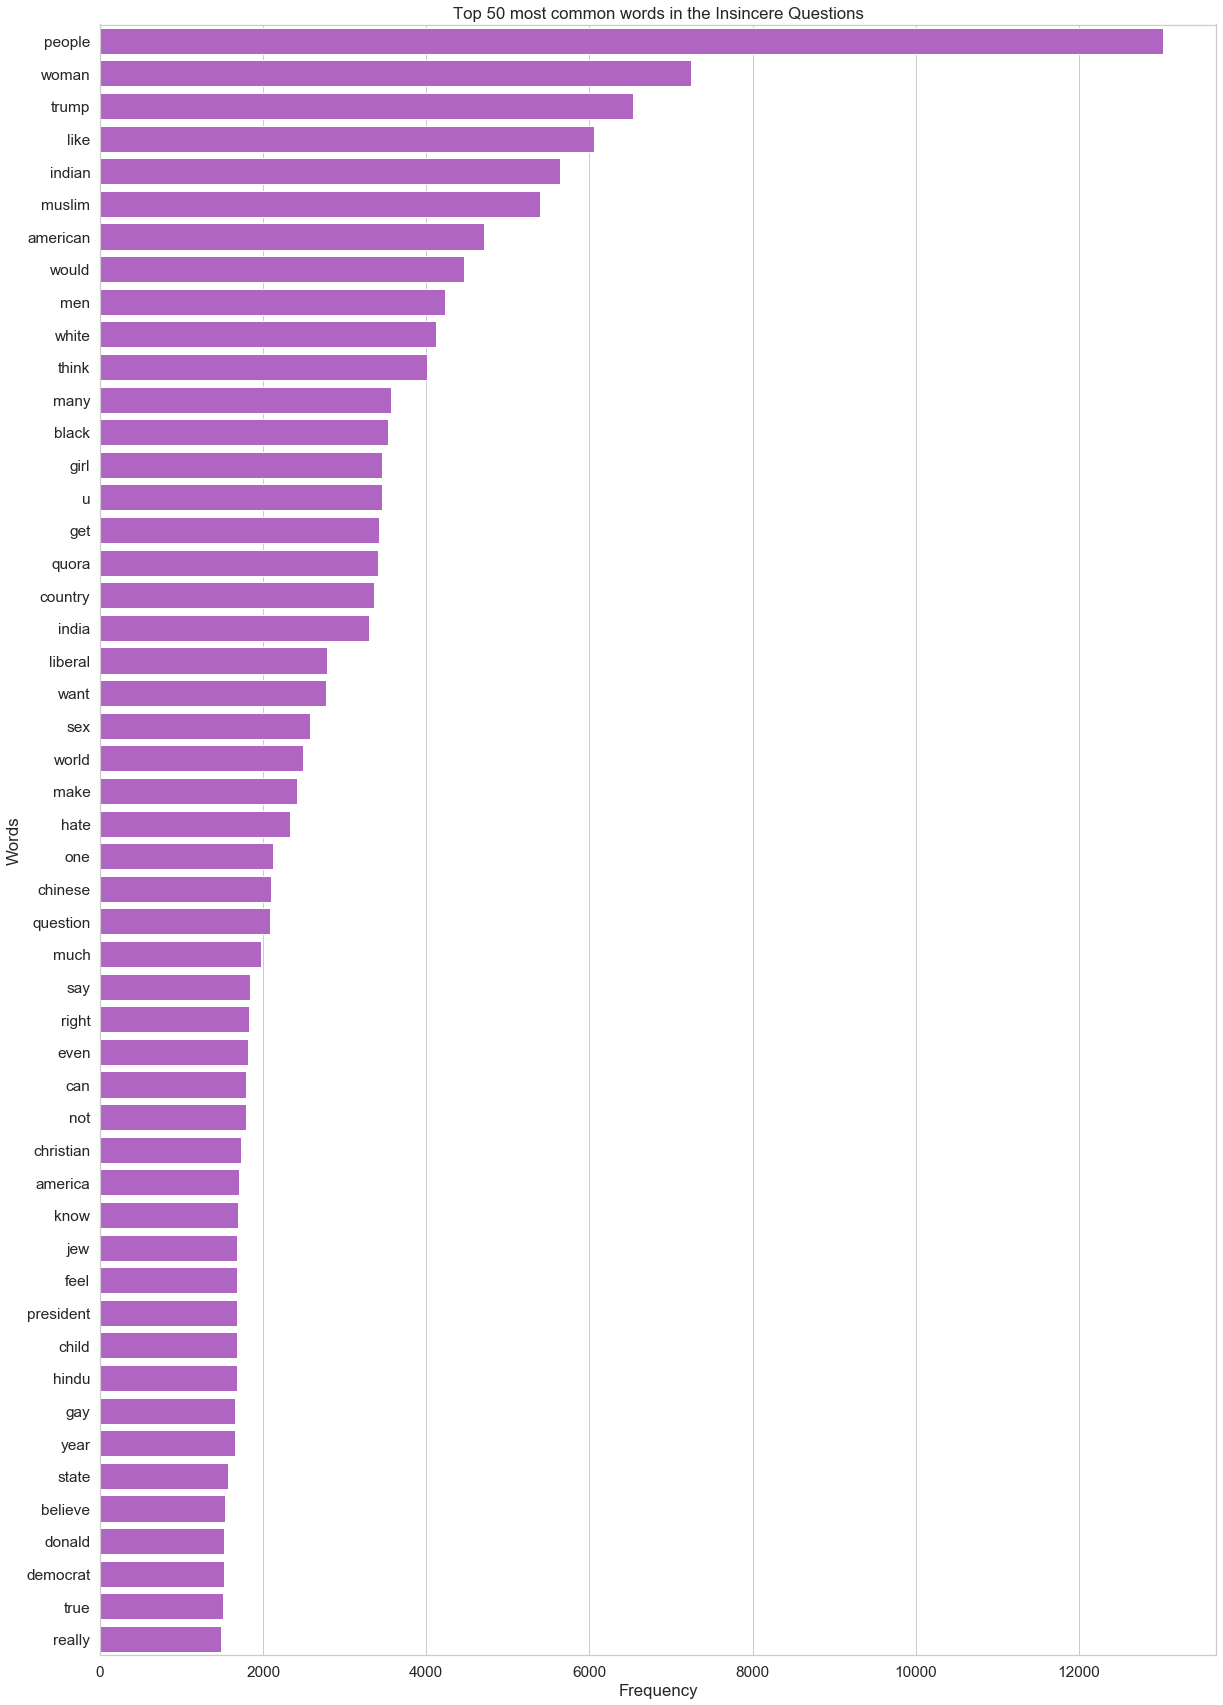

In [34]:
# Removing the stop words before plotting
text_insincere = " ".join(df.loc[df.target == 'Insincere', 'processed_text'])
tokenized_insincere = word_tokenize(text_insincere)
frequency_insincere = Counter(tokenized_insincere)
df_1 = pd.DataFrame(frequency_insincere.most_common(50))

sns.set(font_scale = 1.4, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [20, 30]

word_count_1 = sns.barplot(x = df_1[1], y = df_1[0], color = 'mediumorchid')
word_count_1.set(title = 'Top 50 most common words in the Insincere Questions', xlabel = 'Frequency',
                ylabel = 'Words');

##### Sincere

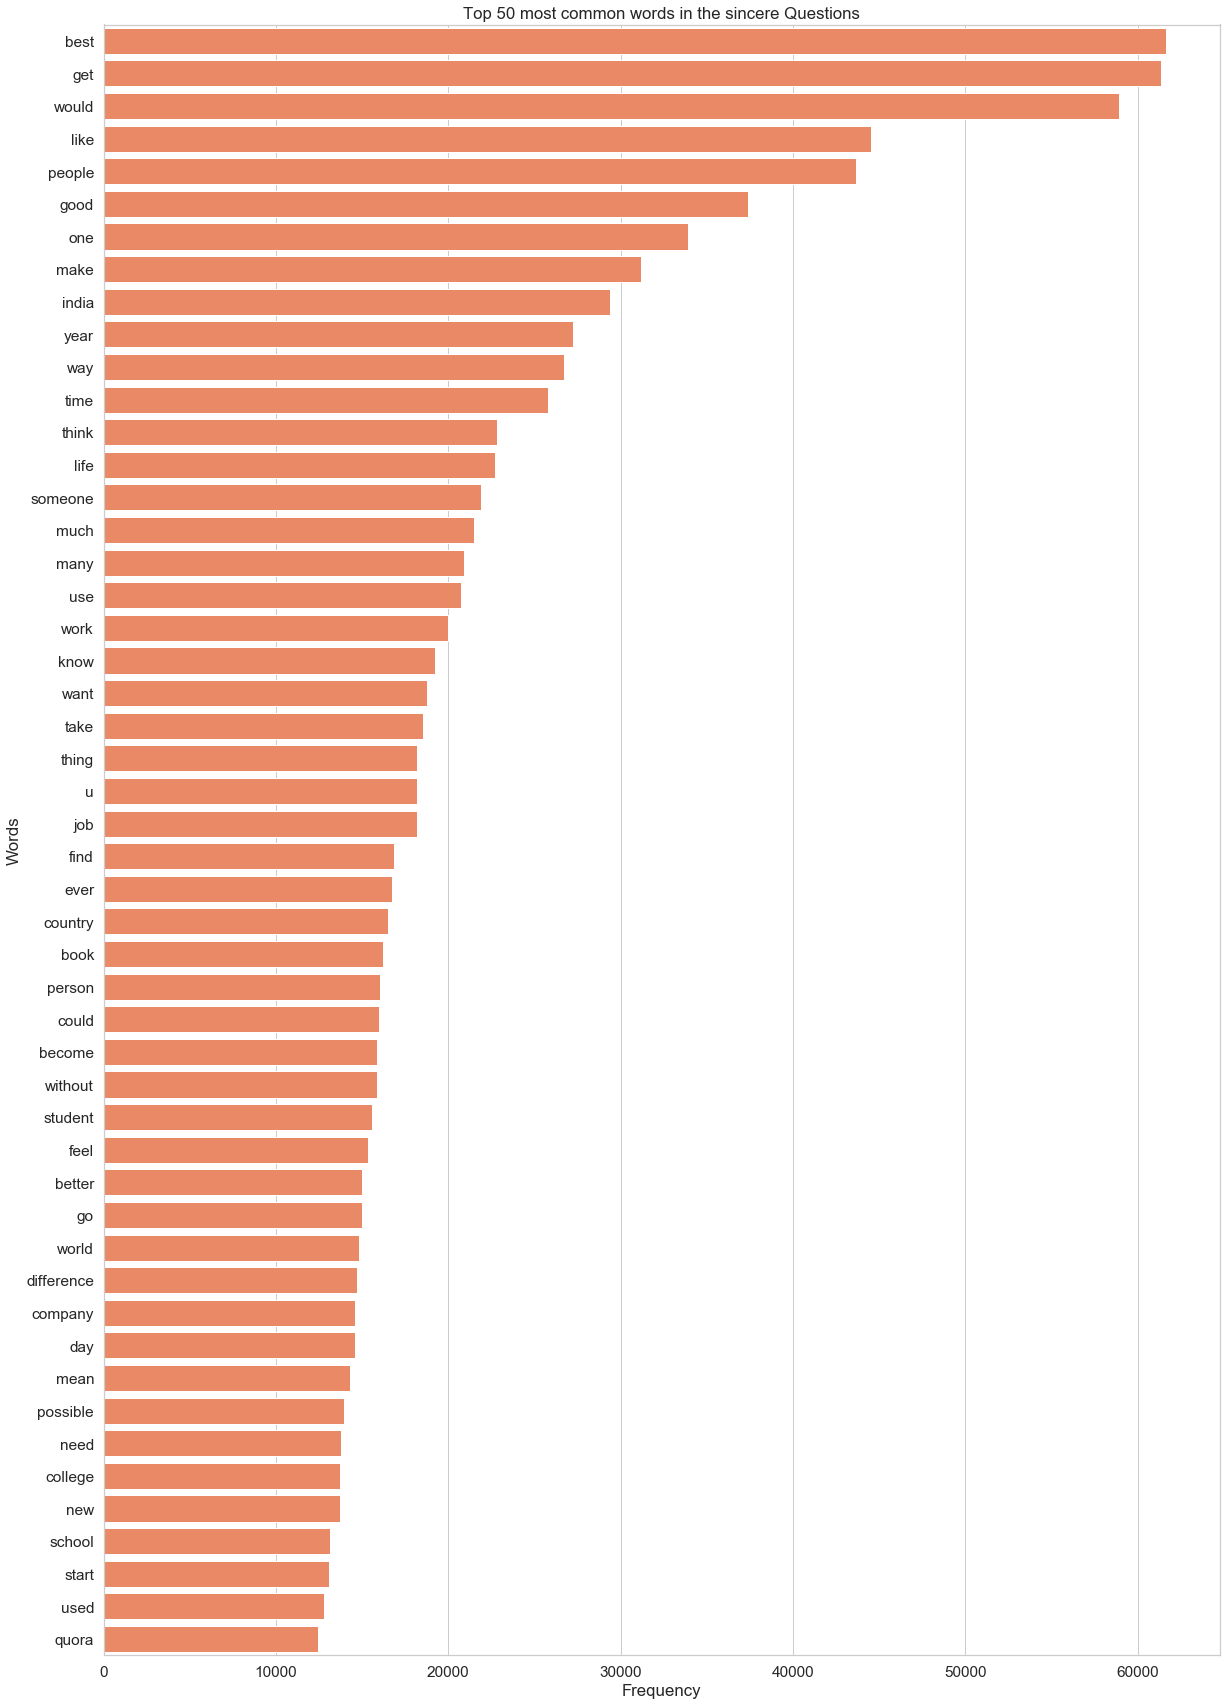

In [35]:
# Removing the stop words before plotting
text_sincere = " ".join(df.loc[df.target == 'Sincere', 'processed_text'])
tokenized_sincere = word_tokenize(text_sincere)
frequency_sincere = Counter(tokenized_sincere)
df_2 = pd.DataFrame(frequency_sincere.most_common(50))

sns.set(font_scale = 1.4, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [20, 30]

word_count_2 = sns.barplot(x = df_2[1], y = df_2[0], color = 'coral')
word_count_2.set(title = 'Top 50 most common words in the sincere Questions', xlabel = 'Frequency',
                ylabel = 'Words');

#### Distribution of Polarity and Subjectivity of the questions

In [36]:
# Polarity of the questions 
def sentiment_polarity(questions):
    # Sentiment polarity of the questions
    pol = []
    for i in questions:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

# Subjectivity of the questions
def sentiment_subjectivity(questions):
    # Sentiment subjectivity of the questions
    sub = []
    for i in questions:
        analysis = TextBlob(i)
        sub.append(analysis.sentiment.subjectivity)
    return sub

# Appeding the polarity and subjectivity of the text in the dataframe
df['polarity'] = sentiment_polarity(df['question_text'])
df['subjectivity'] = sentiment_subjectivity(df['question_text'])

In [37]:
df.head(10)

,qid,question_text,target,processed_text,words_num,words_num_unique,char_num,stopwords_num,punctuation_num,titlecase_num,average_word_len,polarity,subjectivity
0,00002165364db923c7e6,How did Quebec nationalists see their province...,Sincere,quebec nationalist see province nation 1960s,13,13,72,7,1,2,4.615385,0.000,0.000
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",Sincere,adopted dog would encourage people adopt shop,16,15,81,9,2,1,4.125000,0.000,0.000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,Sincere,velocity affect time velocity affect space geo...,10,8,67,3,2,2,5.800000,0.000,0.000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,Sincere,otto von guericke used magdeburg hemisphere,9,9,57,3,1,4,5.444444,0.000,0.000
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,Sincere,convert montra helicon mountain bike changing ...,15,15,77,8,1,3,4.200000,0.000,0.000
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",Sincere,gaza slowly becoming auschwitz dachau treblink...,10,10,72,3,2,6,6.300000,0.450,0.850
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,Sincere,quora automatically ban conservative opinion r...,18,17,113,10,2,2,5.333333,0.000,0.125
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,Sincere,crazy wash wipe grocery germ everywhere,14,14,69,7,2,3,4.000000,-0.600,0.900
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",Sincere,thing dressing moderately different dressing m...,18,17,102,11,3,1,4.722222,0.025,0.675
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,Sincere,ever phase wherein became ignorant people love...,44,39,246,25,4,2,4.613636,0.400,0.600


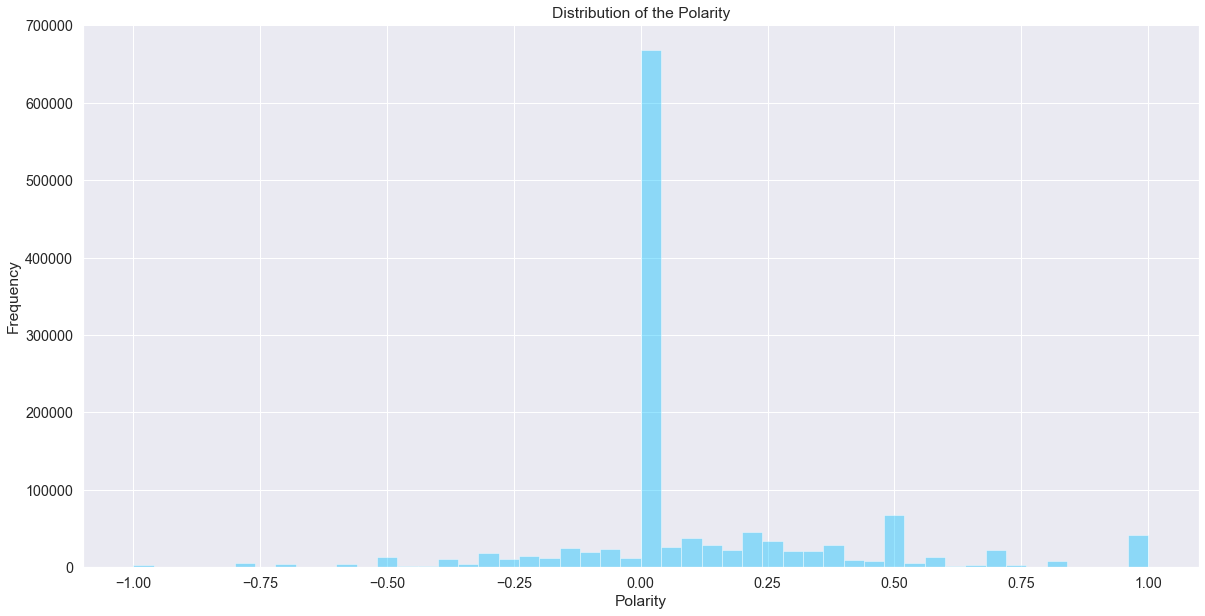

In [38]:
# Distribution plot
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = 'darkgrid', font_scale = 1.3)

dist_ = sns.distplot(df['polarity'], kde = False, color = 'deepskyblue')
# Setting the axes
dist_.set(title = 'Distribution of the Polarity', xlabel = 'Polarity', ylabel = 'Frequency');

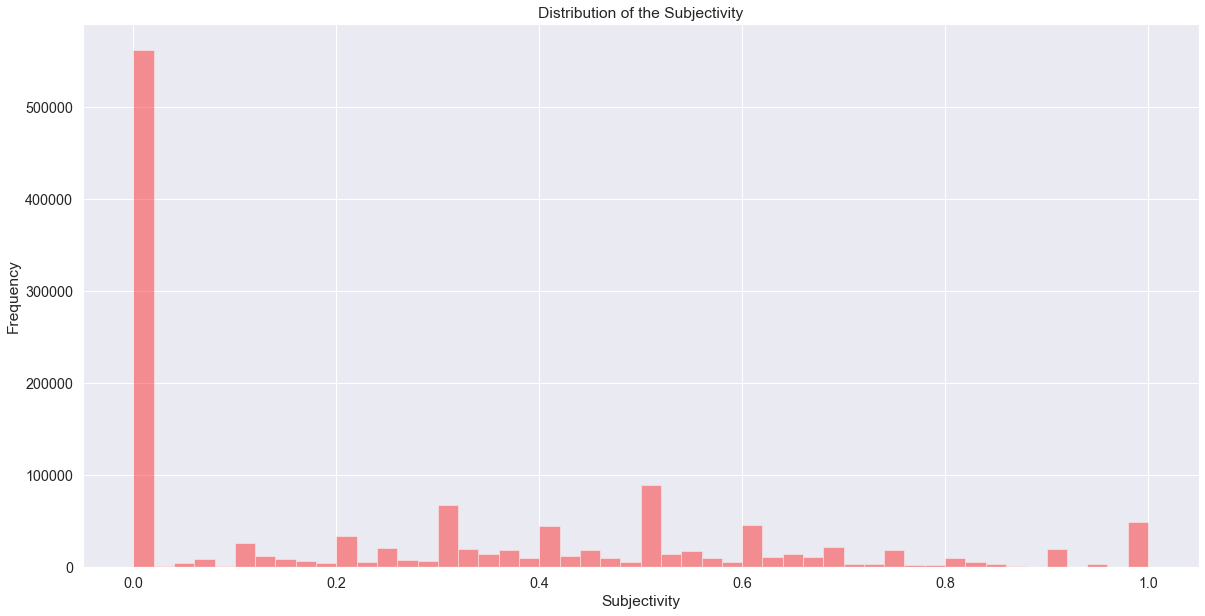

In [39]:
# Distribution plot
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = 'darkgrid', font_scale = 1.3)
dist_ = sns.distplot(df['subjectivity'], kde = False, color = 'red')
# Setting the axes
dist_.set(title = 'Distribution of the Subjectivity', xlabel = 'Subjectivity', ylabel = 'Frequency');

#### Features Correlation Heatmap

In [17]:
# Changing the target values back to original
df['target'] = df['target'].map({'Insincere' : 1,'Sincere' : 0})

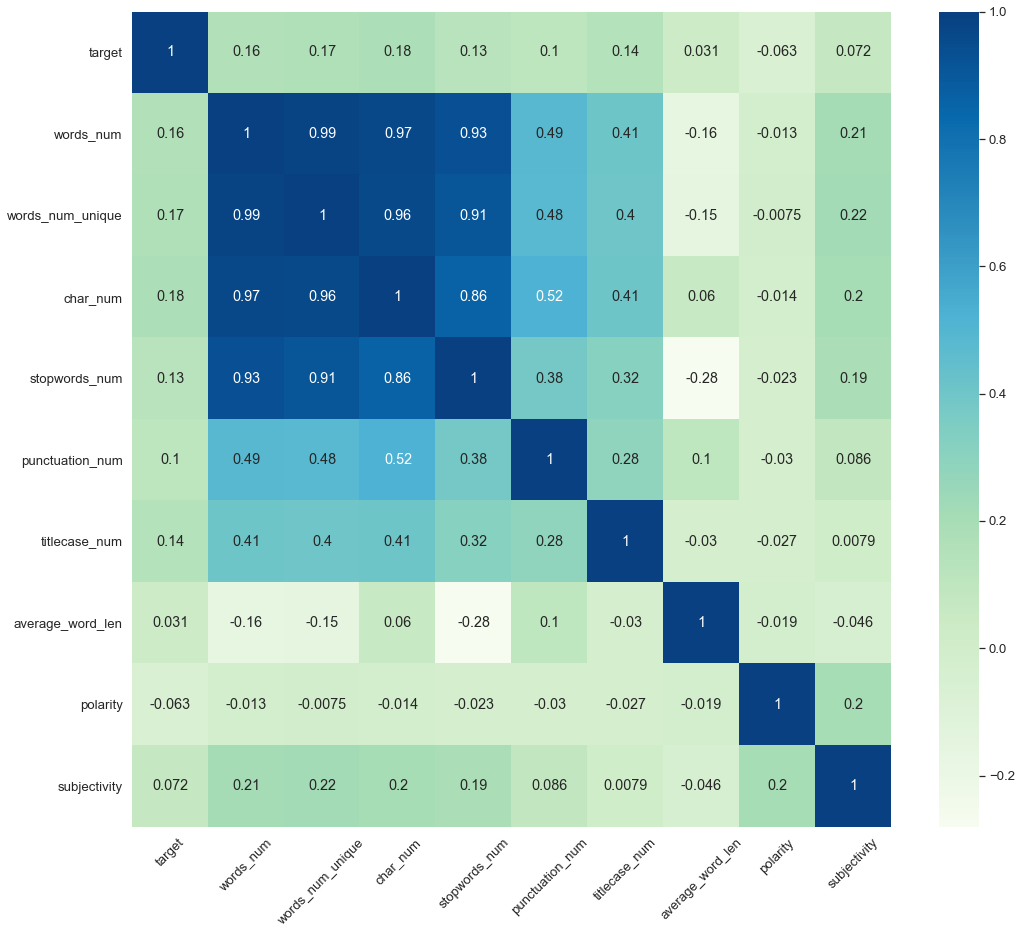

In [41]:
# Setting Parameters
plt.rcParams['figure.figsize'] = [17, 15]
sns.set(font_scale = 1.2)
# Correlation Matrix
corr = df.corr()
# Heatmap
sns_ = sns.heatmap(corr, annot = True, cmap = 'GnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

#### Logistic Regression

In [47]:
# Distribution of target
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [43]:
# Splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['target'], test_size = 0.20, random_state = 0)

# using TFIDF
vect_word = TfidfVectorizer(max_features = 70000, lowercase = True, analyzer = 'word',
                           ngram_range = (1, 3), dtype = np.float64)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

# Fitting and transforming using TFIDF
tr_vect = vect_word.fit_transform(X_train)
ts_vect = vect_word.transform(X_test)

tr_vect_char = vect_char.fit_transform(X_train)
ts_vect_char = vect_char.transform(X_test)

X_train = sparse.hstack([tr_vect, tr_vect_char])
X_test = sparse.hstack([ts_vect, ts_vect_char])

In [44]:
# Training the Logistic Regression
clf_lr = LogisticRegression(C=20, solver='sag').fit(X_train, y_train)

# Predictions
pred_1 = clf_lr.predict(X_test)

In [45]:
# Confusion Matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_1).ravel()
print ("True Negative : ", tn)
print ("False Positive : ", fp)
print ("False Negative : ", fn)
print ("true positive : ", tp)

True Negative :  240725
False Positive :  4424
False Negative :  8103
true positive :  7973


In [46]:
# f1 score
print (metrics.f1_score(y_test, pred_1))

0.5600393355108348


In [52]:
clf_2 = RandomForestClassifier(n_estimators = 100).fit(X, y_train)

In [53]:
pred_2 = clf_2.predict(x_test)

In [54]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_2).ravel()
print ("True Negative : ", tn)
print ("False Positive : ", fp)
print ("False Negative : ", fn)
print ("true positive : ", tp)

True Negative :  303955
False Positive :  2503
False Negative :  14123
true positive :  5950


In [55]:
print (metrics.f1_score(y_test, pred_2))

0.4171632896305124


In [33]:
from sklearn.naive_bayes import GaussianNB

In [37]:
clf_3 = GaussianNB().fit(X, y_train)
pred_3 = clf_3.predict(x_test)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_3).ravel()
print ("True Negative : ", tn)
print ("False Positive : ", fp)
print ("False Negative : ", fn)
print ("true positive : ", tp)

In [13]:
df.head()

,qid,question_text,target,processed_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


### CNN

#### Word Embedding using GloVe

In [14]:
# Opening the GloVe File for embedding
embeddings_index = {}
word_embedding_file = open('glove.840B.300d.txt', encoding="utf-8")
for line in word_embedding_file:
    values = line.split(' ')
    word = values[0]
    coefs = np.array(values[1:], dtype = 'float64')
    embeddings_index[word] = coefs
word_embedding_file.close()

print (len(embeddings_index))

2196016


In [15]:
# Tokenization of the questions for further process
text = []
for question in df['processed_text']:
    tokenize = word_tokenize(question)
    text.append(tokenize)
print ("Tokenization DONE!")
print ()
print (text[0:10])

Tokenization DONE!

[['quebec', 'nationalist', 'see', 'province', 'nation', '1960s'], ['adopted', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'], ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry'], ['otto', 'von', 'guericke', 'used', 'magdeburg', 'hemisphere'], ['convert', 'montra', 'helicon', 'mountain', 'bike', 'changing', 'tyre'], ['gaza', 'slowly', 'becoming', 'auschwitz', 'dachau', 'treblinka', 'palestinian'], ['quora', 'automatically', 'ban', 'conservative', 'opinion', 'reported', 'liberal', 'view'], ['crazy', 'wash', 'wipe', 'grocery', 'germ', 'everywhere'], ['thing', 'dressing', 'moderately', 'different', 'dressing', 'modestly'], ['ever', 'phase', 'wherein', 'became', 'ignorant', 'people', 'loved', 'completely', 'disregarding', 'feelingslives', 'get', 'something', 'go', 'way', 'feel', 'temporarily', 'ease', 'thing', 'change']]


In [16]:
# Defining the parameters
MAX_NUM_WORDS = 50000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

# dictionary to keep the track of the word to num
word_index = tokenizer.word_index

# Padding the sequences
data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)

labels = df.target.values
print (data.shape)
print (labels.shape)

(1306122, 100)
(1306122,)


In [17]:
# Creating the Dimension of the embedding matrix
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

# Creating a dummy embedding matrix so as to change the values according to GloVe
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# all_embs = np.stack(embeddings_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]
# word_index = tokenizer.word_index
# nb_words = min(MAX_NUM_WORDS, len(word_index))
# embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    # Taking the vector of the word from the GloVe
    embedding_vector = embeddings_index.get(word)
    
    # Checking if the word exist then use it for the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Stripping the first vector as the sequence start from 1 and 0th position will always be zero        
#embedding_matrix = embedding_matrix[1:]

print ("The length of the embedding matrix is : ", len(embedding_matrix))
print ("The length of the word_index is : ", len(word_index))

The length of the embedding matrix is :  100001
The length of the word_index is :  233593


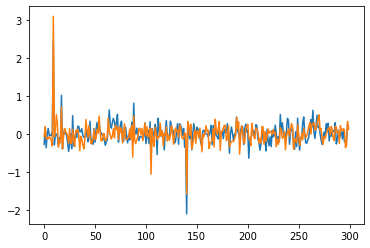

In [18]:
plt.plot(embedding_matrix[1])
plt.plot(embedding_matrix[2])

In [22]:
embedding_layer = Embedding(MAX_NUM_WORDS,
                           EMBEDDING_DIM,
                           embeddings_initializer = Constant(embedding_matrix),
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable = False)

In [29]:
# Recall , Precision and f1 score for the classification task
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Modelling

In [30]:
# Sequential Model
model = Sequential()
model.add(Embedding(num_words, 300, input_length=100, weights= [embedding_matrix], trainable=True))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, recall_m, precision_m])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          30000300  
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,162,465
Trainable params: 30,162,465
Non-trainable params: 0
__________________________________________

In [31]:
# train = data[0:1000000]
# train_label = df['target'].values[0:1000000]
# test = data[1000000:]
# test_label = df['target'].values[1000000:]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 2018)

# Training the model
model.fit(X_train, y_train, validation_split=0.1, epochs = 1, shuffle = True)

Train on 940407 samples, validate on 104490 samples
Epoch 1/1
940407/940407 [==============================] - 12534s 13ms/step - loss: 0.1199 - accuracy: 0.9525 - f1_m: 0.4200 - recall_m: 0.4063 - precision_m: 0.4996 - val_loss: 0.1153 - val_accuracy: 0.9546 - val_f1_m: 0.4340 - val_recall_m: 0.4124 - val_precision_m: 0.5231


In [32]:
# Finding the best threshold for the prediction
pred = model.predict(X_test)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (pred>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5735939369764659
F1 score at threshold 0.11 is 0.5828946232847156
F1 score at threshold 0.12 is 0.590683889232947
F1 score at threshold 0.13 is 0.5976537729866835
F1 score at threshold 0.14 is 0.6027720027720027
F1 score at threshold 0.15 is 0.6069082432718796
F1 score at threshold 0.16 is 0.6107152282924254
F1 score at threshold 0.17 is 0.6147498962478335
F1 score at threshold 0.18 is 0.6179510695783655
F1 score at threshold 0.19 is 0.6196686640817765
F1 score at threshold 0.2 is 0.6225436332507092
F1 score at threshold 0.21 is 0.6254117280908785
F1 score at threshold 0.22 is 0.6262535863757206
F1 score at threshold 0.23 is 0.628722523436874
F1 score at threshold 0.24 is 0.6292104408101377
F1 score at threshold 0.25 is 0.6297727708795877
F1 score at threshold 0.26 is 0.6302175843694494
F1 score at threshold 0.27 is 0.6306235423047741
F1 score at threshold 0.28 is 0.6311745959480992
F1 score at threshold 0.29 is 0.6304598363489686
F1 score at threshold 0.

In [22]:
pred_1 = (pred>0.30).astype(int)

In [23]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_1).ravel()
print ("True Negative : ", tn)
print ("False Positive : ", fp)
print ("False Negative : ", fn)
print ("true positive : ", tp)

True Negative :  296972
False Positive :  9486
False Negative :  6329
true positive :  13744


In [159]:
a, b, c = f1_m(test_label, pred)

In [160]:
a

<tf.Tensor 'truediv:0' shape=() dtype=float32>

In [161]:
b

<tf.Tensor 'truediv_1:0' shape=() dtype=float32>

In [162]:
c

<tf.Tensor 'mul_1:0' shape=() dtype=float32>

In [52]:
labels = to_categorical(np.asarray(df['target']))

Tokenization DONE!
[['quebec', 'nationalist', 'see', 'province', 'nation', '1960s'], ['adopted', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'], ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry'], ['otto', 'von', 'guericke', 'used', 'magdeburg', 'hemisphere'], ['convert', 'montra', 'helicon', 'mountain', 'bike', 'changing', 'tyre'], ['gaza', 'slowly', 'becoming', 'auschwitz', 'dachau', 'treblinka', 'palestinian'], ['quora', 'automatically', 'ban', 'conservative', 'opinion', 'reported', 'liberal', 'view'], ['crazy', 'wash', 'wipe', 'grocery', 'germ', 'everywhere'], ['thing', 'dressing', 'moderately', 'different', 'dressing', 'modestly'], ['ever', 'phase', 'wherein', 'became', 'ignorant', 'people', 'loved', 'completely', 'disregarding', 'feelingslives', 'get', 'something', 'go', 'way', 'feel', 'temporarily', 'ease', 'thing', 'change']]


In [94]:
data = pad_sequences(sequences, maxlen=20)

In [95]:
data

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4]])

In [97]:
tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts([['sumit', 'mishra'],['is', 'best']])

In [99]:
sequences = tokenizer.texts_to_sequences([['sumit', 'mishra'],['is', 'best']])

In [100]:
sequences

[[1, 2], [3, 4]]

In [86]:
a = tokenizer.word_index

In [87]:
a

{'sumit': 1, 'mishra': 2, 'is': 3, 'best': 4}

### BERT

In [12]:
import csv
import os
import sys
import logging
logger = logging.getLogger()
csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.

class InputExample(object):
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""
    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()
    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()
    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

class BinaryClassificationProcessor(DataProcessor):
    """Processor for binary classification dataset."""
    def get_train_examples(self, data_dir):
        """See base class."""
        #print('rekha--------------------')
        #print(os.path.join(data_dir, "train.tsv"))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if(len(line) == 0):
                print('Found empty line')
            elif(len(line)<4):
                print(line)
#                 print('line[0]', line[0])
#                 print('line[1]', line[1])
#                 print('line[2]', line[2])
#                 print('line[3]', line[3])
            else:
                #guid = "%s-%s" % (set_type, i)
                guid = line[0]
                text_a = line[3]
                label = line[1]
                examples.append(
                    InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples
    
class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def convert_example_to_feature(example_row):
    # return example_row
    example, label_map, max_seq_length, tokenizer, output_mode = example_row
    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] * len(tokens)
    if tokens_b:
        tokens += tokens_b + ["[SEP]"]
        segment_ids += [1] * (len(tokens_b) + 1)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    # Zero-pad up to the sequence length.
    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)
    return InputFeatures(input_ids=input_ids,
                         input_mask=input_mask,
                         segment_ids=segment_ids,
                         label_id=label_id)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['question_text'], df['target'], test_size = 0.20, random_state = 0)

In [14]:
train_df_bert = pd.DataFrame({
    'id': range(len(X_train)),
    'label': y_train,
    'alpha': ['a']*X_train.shape[0],
    'text': X_train[:]
})

train_df_bert.head()

,id,label,alpha,text
554405,0,0,a,Which on going ICO has the potential to give 1...
755073,1,0,a,How does one go from Crypto to Fiat (EUR) to w...
631684,2,0,a,Can police hack deleted fb account?
196824,3,0,a,What is the most doable idea that can change t...
835453,4,0,a,Why we put space after slash?


In [15]:
dev_df_bert = pd.DataFrame({
    'id': range(len(X_test)),
    'label': y_test,
    'alpha': ['a']*X_test.shape[0],
    'text': X_test[:]
})
dev_df_bert.head()

,id,label,alpha,text
879280,0,0,a,Whether advances from customers are to be rein...
43285,1,0,a,How can you get help?
740986,2,0,a,How does one succeed as a lecturer in medicine...
472594,3,0,a,What is the purpose behind the Yellow wallpaper?
453814,4,0,a,What is the problem by applying under non spp ...


In [16]:
train_df_bert.to_csv('data/train.tsv', sep = '\t', index = False, header = False)
dev_df_bert.to_csv('data/dev.tsv', sep = '\t', index = False, header = False)

In [17]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from tools import *
import convert_examples_to_features

In [18]:
DATA_DIR = "data/"

BERT_MODEL = "bert-based-cased"

TASK_NAME = "Quora"

OUTPUT_DIR = f'outputs/{TASK_NAME}/'

REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

CACHE_DIR = 'cache/'

MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [19]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [20]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [21]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

['"']
[' Burmese army throws muslim children into fire infront of their mothers, Aung su kyi is silent...so is world. hypocrite much?"']
['"']
Found empty line
['*Spoilers*']
['*Spoilers*']
['*Spoilers*']
['*Spoilers*']
Found empty line
['1)Make warping look quite a bit like an hyperspace jump']
['2)what in the world were those bright particles as soon as they jumped.']
['3)Why in the world did they make it possible for two entities to react in warp space in separate jumps.']
['4)Why did Spock get emotions for this movie.']
['5)What was the point of hiding the ""Enterprise"" underwater.']
["6)When they were intercepted by the dark ship, how come they reached Earth when they were far away from her.(I don't seem to remember the scene where they warp to earth)."]
["7)How did the ship enter earth's atmosphere when it wasnt even in orbit."]
['8)When Scotty opened the door of the black ship , how come pike and khan didn\'t slow down?"']
['life"" and ""Fire of my loins""?']
[' "']
['"']


In [39]:
df.loc[df.processed_text == '', :]

,qid,question_text,target,processed_text
29878,05d74f7b56ccf7a96db1,How and where are you?,0,
31712,0634a54516e48a055d1f,What is www.thehushpost.com?,0,
40137,07dade03041e331943cd,"Why, are we all here?",0,
50230,09d71be32e81e0dc1b90,What you have in yourself?,0,
71452,0e0282f09ce23bbe0938,Who is why?,0,
...,...,...,...,...
1272316,f957e525b2cf7ee3ae4d,What is http://plexco.in?,0,
1273205,f98449fca1a2afdff515,What is www.tick.chat?,0,
1283111,fb77148649593ba07ad3,"What, how and why are what how and why?",0,
1289343,fcb27d17d5e712b98d27,What is this http://yamechanic.com/534u?,0,


In [29]:
df['processed_text'].isna().sum(axis = 0)

0

In [40]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)

In [42]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [43]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

100%|██████████| 213450/213450 [00:00<00:00, 299097.00B/s]


In [44]:
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

In [ ]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 1044897 examples..
Spawning 11 processes..


In [ ]:
with open(DATA_DIR + "train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

In [ ]:
with open(DATA_DIR + "train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

In [ ]:
# Load pre-trained model (weights)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

In [ ]:
model.to(device)